<a href="https://colab.research.google.com/github/Muhammad-Taufiq-Khan/Vision-Blood-Cancer-Stage-Detection/blob/main/notebooks/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install Dependencies

In [ ]:
import os 
import math
import shutil 
import glob
import keras
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 1. Fetch dataset from kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mehradaria/leukemia # Download Dataset
! unzip leukemia.zip # Unzip

In [ ]:
# Count the number of images in the respective classes
def ClassFreq(ROOT_DIR):
  number_of_images = {}
  for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir))) # os.listdir() returns the elements on the specific folder
  print(number_of_images.items())

ClassFreq("/content/Original")

dict_items([('Benign', 504), ('Early', 985), ('Pre', 963), ('Pro', 804)])


# 3. Split Dataset

In [ ]:
ROOT_DIR = "/content/Original"

def dataFolder(path, split):
  number_of_images = {}
  for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

  # Creates directory for train, test and validation set
  # Create separate folders for Training, Validation and Testing
  if not os.path.exists("./"+path): # When <path> directory is not available in the root directory
    os.mkdir("./"+path)             # make directory

    for dir in os.listdir(ROOT_DIR): #For the classes in the Root directory
      os.makedirs("./"+path+"/"+dir)      # create new directoris
      
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size = (math.floor(split*number_of_images[dir])-5), replace = False):
        O = os.path.join(ROOT_DIR, dir, img)
        D = os.path.join("./"+path, dir)
        shutil.copy(O,D)
        os.remove(O)
        
  else:
    print(f"{path} directory already exists")

  print(f"{path} directory has been created")


#Split Dataset and create directory
dataFolder("train",0.7)
dataFolder("val",0.15)
dataFolder("test",0.15)

#Show data frequency
ClassFreq("/content/train")
ClassFreq("/content/val")
ClassFreq("/content/test")

train directory has been created
val directory has been created
test directory has been created
dict_items([('Benign', 347), ('Early', 684), ('Pre', 669), ('Pro', 557)])
dict_items([('Benign', 18), ('Early', 40), ('Pre', 39), ('Pro', 32)])
dict_items([('Benign', 15), ('Early', 34), ('Pre', 33), ('Pro', 27)])


# 4. Preprocessing Images

In [ ]:
def preprocessingImages(path):
  """
  Input: path
  Output: Generated Data
  """
  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range=0.2,preprocessing_function=preprocess_input, horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size = 32,  class_mode= "categorical")
  train_step = image.n//32
  return image, train_step

In [ ]:
def ScaleImages(path):
  """
  Input: path
  Output: Generated Data
  """
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input)
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size = 32, class_mode= "categorical")
  steps = image.n//32
  return image, steps

In [ ]:
train_path = "/content/train"
test_path = "/content/test"
val_path = "/content/val"

train_data, train_step = preprocessingImages(train_path)
val_data, val_steps = ScaleImages(val_path)
test_data, test_steps = ScaleImages(test_path)

train_data.class_indices
print(test_data.class_indices)
print(val_data.class_indices)

Found 2257 images belonging to 4 classes.
Found 129 images belonging to 4 classes.
Found 109 images belonging to 4 classes.
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}


# 5. Model Building 

In [ ]:
# Downloading MobileNet model
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
  layer.trainable = False

X= Flatten()(base_model.output)
X= Dense(units=4, activation="softmax")(X)
model = Model(base_model.input, X)
model.compile(optimizer="rmsprop", loss=keras.losses.categorical_crossentropy, metrics = ["accuracy"])

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

# 6. Training and Validation

In [ ]:
mc = ModelCheckpoint(filepath="bestmodel.h5", 
                     monitor="val_accuracy", 
                     verbose=1, 
                     save_best_only = True)

es = EarlyStopping(monitor="val_accuracy", 
                   min_delta=0.01, 
                   patience= 11, 
                   verbose=1)
cb = [mc,es]
hist = model.fit_generator(train_data,
                           steps_per_epoch=train_step,
                           epochs = 70,
                           validation_data = val_data,
                           validation_steps=val_steps,
                           callbacks=cb)

Epoch 1/70
70/70 [==============================] - ETA: 0s - loss: 2.8850 - accuracy: 0.7789
Epoch 1: val_accuracy improved from -inf to 0.94531, saving model to bestmodel.h5
70/70 [==============================] - 34s 375ms/step - loss: 2.8850 - accuracy: 0.7789 - val_loss: 0.3133 - val_accuracy: 0.9453
Epoch 2/70
70/70 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.8957
Epoch 2: val_accuracy improved from 0.94531 to 0.96094, saving model to bestmodel.h5
70/70 [==============================] - 25s 352ms/step - loss: 1.0564 - accuracy: 0.8957 - val_loss: 0.2074 - val_accuracy: 0.9609
Epoch 3/70
70/70 [==============================] - ETA: 0s - loss: 0.7198 - accuracy: 0.9245
Epoch 3: val_accuracy improved from 0.96094 to 0.97656, saving model to bestmodel.h5
70/70 [==============================] - 25s 362ms/step - loss: 0.7198 - accuracy: 0.9245 - val_loss: 0.1429 - val_accuracy: 0.9766
Epoch 4/70
70/70 [==============================] - ETA: 0s - loss: 0.

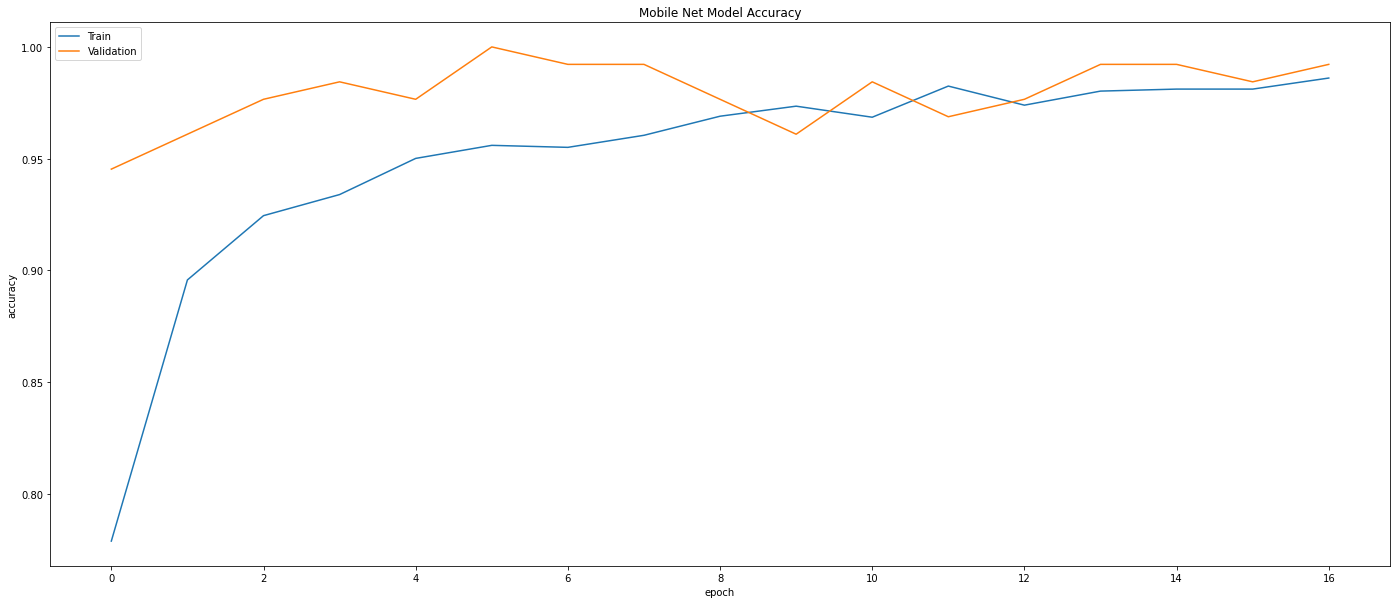

In [ ]:
# summarize history for accuracy --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Mobile Net Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Accuracy2.png")
plt.show()

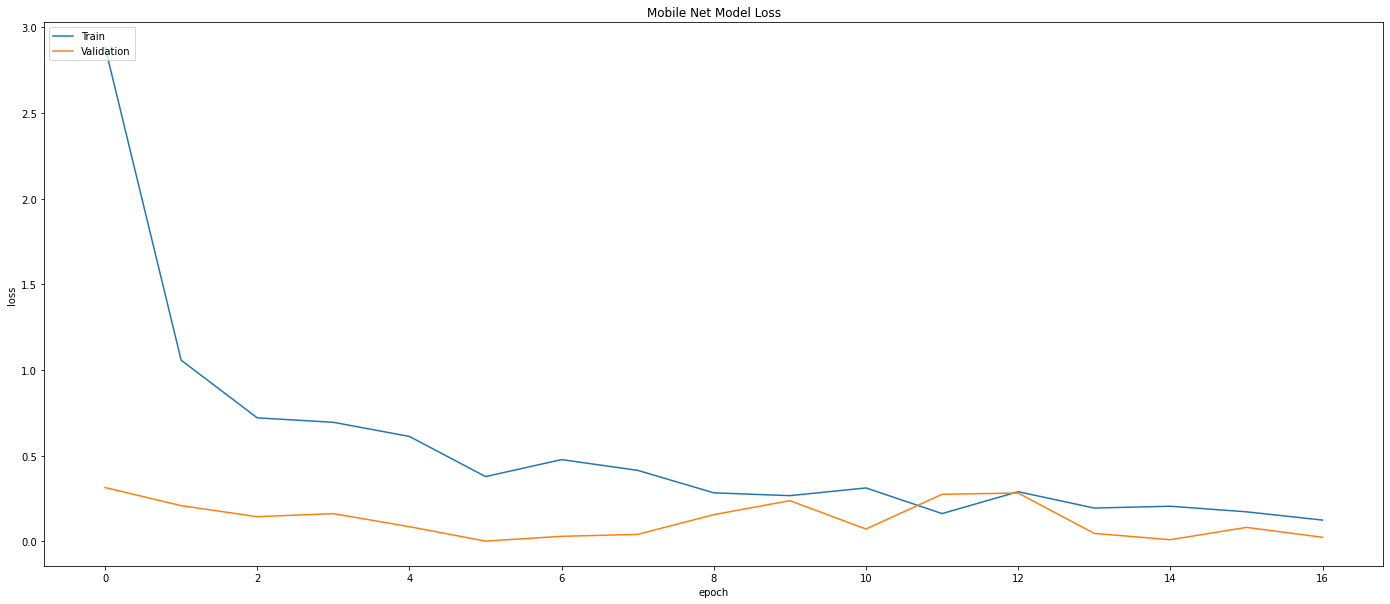

In [ ]:
# summarize history for loss --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Mobile Net Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Validation2.png")
plt.show()

# 8. Testing Model

In [ ]:
best_model_path = "/content/bestmodel.h5"
model = load_model(best_model_path)
acc = model.evaluate_generator(test_data)[1] # Accuracy
los = model.evaluate_generator(test_data)[0] # Loss
print(f"Testing Accuracy: {acc} and Loss: {los}")

Testing Accuracy: 0.9816513657569885 and Loss: 0.4318927526473999


# 9. Random Predict

1/1 [==============================] - 0s 32ms/step
Current stage: "Benign" and Class: 0



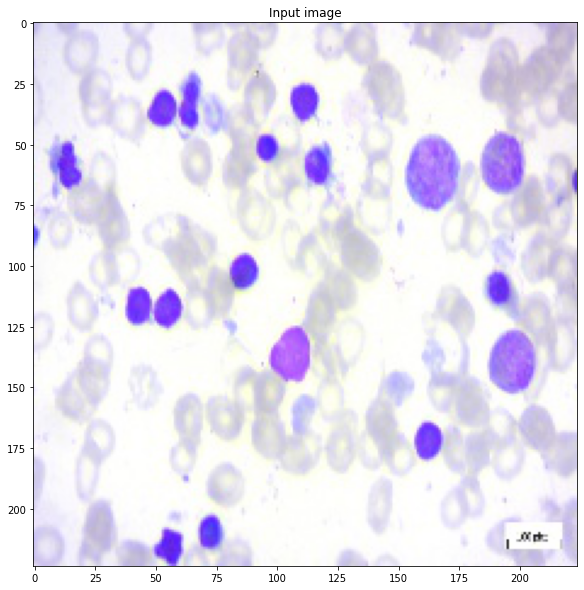

In [ ]:
# Random Check
def random_predict(path):
  img = load_img(path, target_size=(224,224))
  input_arr = img_to_array(img)/255
  input_arr = np.array([input_arr])
  
  # print(input_arr.shape)
  pred = np.argmax(model.predict(input_arr))
  if pred == 0:
    print(f'Current stage: "Benign" and Class: {pred}')
  elif pred == 1:
    print(f'Current stage: "Early" and Class: {pred}')
  elif pred == 2:
    print(f'Current stage: "Pre-B" and Class: {pred}')
  elif pred == 3:
    print(f'Current stage: "Pro-B" and Class: {pred}')
  else: print('unrecognized')
  print()

  plt.figure(figsize=(24, 10))
  plt.imshow(input_arr[0])
  # To display the image
  plt.title("Input image")
  plt.show()


# path = "/content/test/Early/WBC-Malignant-Early-123.jpg"
path = "/content/test/Benign/WBC-Benign-185.jpg"
random_predict(path)

In [ ]:
# convert notebook to html
! pip install nbconvert
! jupyter nbconvert --to html ALL_Cancer_Stage_Detection_using_MobileNet.ipynb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[NbConvertApp] Converting notebook ALL_Cancer_Stage_Detection_using_MobileNet.ipynb to html
[NbConvertApp] Writing 1163029 bytes to ALL_Cancer_Stage_Detection_using_MobileNet.html
